In [1]:
import pandas as pd
import numpy as np
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE, MeanAbsoluteError
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf 

2021-08-26 11:41:36.126766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-26 11:41:36.126799: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
#data_gemini = pd.read_csv("../data/BTCUSD_4hours.csv")

In [ ]:
#data_gemini = data_gemini.drop(columns="Unnamed: 0").set_index("date")

# Functions and Pipeline

In [188]:
def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011. The index is set to the date.
    """
    data = pd.read_csv("../data/BTCUSD_4hours.csv")
    data_train = data.drop(columns="Unnamed: 0").set_index("date")
    return data_train

def add_ema(data, tspan=[12,26,20,50,34,55]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data.log_close.ewm(span=t).mean()
    return data

def computeRSI (data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data['log_close'], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data

def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down

def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    return data

def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data


In [189]:
# #Feature engineering Pipeline
# data = get_train_data()
# add_ema(data)
# add_stoch_rsi(data)
# add_bollinger(data,data.log_close)
# add_vol_roc(data)

In [196]:
def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data.log_close)
    add_vol_roc(data)
    data = data.copy()
    data = data.dropna()
    data.drop(index=["2012-01-10 20:00:00"], axis = 0,inplace=True)
    return data

def minmaxscaling(data_train):
    minmax_scaler = MinMaxScaler(feature_range = (0,1))
    minmax_scaler.fit(data_train)
    data_train_scaled = minmax_scaler.transform(data_train)
    min1 = minmax_scaler.data_min_ # [5:9] for log_prices
    range1 = minmax_scaler.data_range_ #[5:9]
    return data_train_scaled, min1, range1

def create_xy(data_train_scaled,window_size=72, horizon=1):
    data_train_subsequences = []
    fake_y_train = []
    for k in range(len(data_train_scaled)-(window_size-1)-horizon):
        data_train_subsequences.append(data_train_scaled[k:k+window_size])
        fake_y_train.append(data_train_scaled[k+window_size])
    X_train = np.array(data_train_subsequences)
    y_train = np.array(fake_y_train) #[:,5:9]
    return X_train, y_train

In [197]:
data = get_train_data()
feature_engineer(data)
data, min1, range1 = minmaxscaling(data)
X_train, y_train = create_xy(data)

In [202]:
print(f"X_train {X_train.shape}, y_train {y_train.shape}")

X_train (20768, 72, 22), y_train (20768, 22)


In [ ]:
(16574, 72, 1)
(16574, 1)

In [151]:
# data_gemini = data.copy()
# data_gemini = data_gemini.dropna()
# data_gemini.drop(index=["2012-01-10 20:00:00"], axis = 0,inplace=True)

# test

In [117]:
data_gemini = pd.read_csv("../raw_data/gemini_BTCUSD_1hr.csv")


data_gemini.index
data_gemini.reset_index(inplace=True)
column_names=['Unix Timestamp','Date','Symbol','Open','High','Low','Close','Volume']
data_gemini.columns = column_names
df_gemini = data_gemini.iloc[1:].copy()

#transform to datetime
df_gemini['Date'] = pd.to_datetime(df_gemini['Date'])

#transform numerics into floats
numerics = ['Open','High','Low','Close','Volume']
for k in numerics:
    df_gemini[k] = pd.to_numeric(df_gemini[k])
    
#set date to index 
df_gemini = df_gemini.set_index('Date')

df_gemini = df_gemini.drop(columns=['Unix Timestamp', 'Symbol'])

In [118]:
data_gemini = df_gemini.resample("4H").mean()

for x in ['Open', 'High', 'Low', 'Close']:
    data_gemini[f'log_{x}'] = data_gemini[x].apply(lambda x: np.log(x))

In [119]:
data_gemini

,Open,High,Low,Close,Volume,log_Open,log_High,log_Low,log_Close
Date,,,,,,,,,
2015-10-08 12:00:00,163.333333,245.0000,163.1400,244.973333,2.692410,5.095793,5.501258,5.094609,5.501149
2015-10-08 16:00:00,244.540000,244.7250,244.0675,244.310000,3.259453,5.499379,5.500135,5.497445,5.498438
2015-10-08 20:00:00,243.975000,243.9875,243.7675,243.962500,2.659915,5.497066,5.497117,5.496215,5.497015
2015-10-09 00:00:00,243.687500,243.6875,243.6000,243.600000,0.750000,5.495887,5.495887,5.495528,5.495528
2015-10-09 04:00:00,243.600000,243.6000,243.6000,243.600000,0.000000,5.495528,5.495528,5.495528,5.495528
...,...,...,...,...,...,...,...,...,...
2021-08-12 08:00:00,45323.657500,45529.0675,44998.1425,45190.977500,69.830994,10.721584,10.726106,10.714376,10.718653
2021-08-12 12:00:00,44491.795000,44643.4775,44186.6725,44353.090000,114.602881,10.703060,10.706463,10.696178,10.699938
2021-08-12 16:00:00,44198.082500,44414.5750,44034.7175,44248.827500,84.168365,10.696437,10.701323,10.692734,10.697584


### Temporal Train-Test Split

In [155]:
data_gemini.keys()

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'ema26', 'ema20', 'ema50', 'ema34',
       'ema55', 'rsi', 'K', 'D', 'sma', 'bollinger_up', 'bollinger_down',
       'vol_roc'],
      dtype='object')

In [156]:
data_gemini.drop(columns=['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'ema12', 'ema26', 'ema20', 'ema50', 'ema34',
       'ema55', 'rsi', 'K', 'D', 'sma', 'bollinger_up', 'bollinger_down',
       'vol_roc'], inplace=True)

In [157]:
train_percentage = 80

In [158]:
train_len = int(len(data_gemini) * train_percentage/100)
train_len

16646

In [159]:
data_train = data_gemini[:train_len]
data_test = data_gemini[train_len:]

In [160]:
print(data_train.shape)
print(data_test.shape)

(16646, 1)
(4162, 1)


### scaling

In [161]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [162]:
min1 = minmax_scaler.data_min_ #[5:9]
min1

array([1.44133982])

In [163]:
range1 = minmax_scaler.data_range_ #[5:9]
range1

array([8.43679108])

## Basic Model

### create x and y array

In [164]:
window_size = 72 #because we want to base our prediction on 3 weeks (72*4 hours)
horizon = 1 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size])

In [165]:
len(data_train_subsequences)

16574

In [166]:
len(fake_y_train)

16574

In [167]:
X_train = np.array(data_train_subsequences)
y_train = np.array(fake_y_train) #[:,5:9]

In [168]:
print(X_train.shape)
print(y_train.shape)

(16574, 72, 1)
(16574, 1)


In [169]:
X_train

array([[[0.06026941],
        [0.06323924],
        [0.05895322],
        ...,
        [0.03934152],
        [0.04465406],
        [0.04498708]],

       [[0.06323924],
        [0.05895322],
        [0.05980595],
        ...,
        [0.04465406],
        [0.04498708],
        [0.04561419]],

       [[0.05895322],
        [0.05980595],
        [0.05895628],
        ...,
        [0.04498708],
        [0.04561419],
        [0.04541651]],

       ...,

       [[0.92350341],
        [0.92307521],
        [0.92303422],
        ...,
        [0.89585561],
        [0.89660678],
        [0.89700312]],

       [[0.92307521],
        [0.92303422],
        [0.92345363],
        ...,
        [0.89660678],
        [0.89700312],
        [0.89659783]],

       [[0.92303422],
        [0.92345363],
        [0.92366228],
        ...,
        [0.89700312],
        [0.89659783],
        [0.89599154]]])

In [170]:
y_train

array([[0.04561419],
       [0.04541651],
       [0.04621532],
       ...,
       [0.89659783],
       [0.89599154],
       [0.89520348]])

### Initialize a model & set layers

In [171]:
# Initialize a model, add a masking layer,LSTM,Dense Layers 
model = Sequential()
#model.add(normalizer)
#model.add(layers.Masking(mask_value=-1))
model.add(layers.LSTM(units=16, activation='tanh',input_shape = X_train[0].shape, return_sequences = True)) # first run 64 units
model.add(layers.LSTM(units=12,return_sequences = False, activation = "tanh"))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation="relu"))  #output == number of features

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 72, 16)            1152      
_________________________________________________________________
lstm_11 (LSTM)               (None, 12)                1392      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                130       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 2,685
Trainable params: 2,685
Non-trainable params: 0
_________________________________________________________________


### Compile Model 


In [172]:
# later add: es = EarlyStopping(patience=3, restore_best_weights=True)

model.compile(optimizer='rmsprop', loss="mse", metrics="mae")

### Fit Model

In [173]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=8, restore_best_weights=True)

In [174]:
model.fit(X_train,y_train,epochs=100, batch_size=64, validation_split=0.2, callbacks=[es])

Epoch 1/100
208/208 [==============================] - 11s 45ms/step - loss: 0.3070 - mae: 0.5049 - val_loss: 0.7562 - val_mae: 0.8685
Epoch 2/100
208/208 [==============================] - 9s 44ms/step - loss: 0.3070 - mae: 0.5049 - val_loss: 0.7562 - val_mae: 0.8685
Epoch 3/100
208/208 [==============================] - 9s 44ms/step - loss: 0.3070 - mae: 0.5049 - val_loss: 0.7562 - val_mae: 0.8685
Epoch 4/100
208/208 [==============================] - 10s 46ms/step - loss: 0.3070 - mae: 0.5049 - val_loss: 0.7562 - val_mae: 0.8685
Epoch 5/100
208/208 [==============================] - 11s 55ms/step - loss: 0.3070 - mae: 0.5049 - val_loss: 0.7562 - val_mae: 0.8685
Epoch 6/100
208/208 [==============================] - 10s 48ms/step - loss: 0.3070 - mae: 0.5049 - val_loss: 0.7562 - val_mae: 0.8685
Epoch 7/100
208/208 [==============================] - 11s 52ms/step - loss: 0.3070 - mae: 0.5049 - val_loss: 0.7562 - val_mae: 0.8685
Epoch 8/100
208/208 [==============================] - 10

## create X_test & y_test

In [175]:
#with the same window_size & horizon as the train data
window_size = 72
horizon = 1
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size])

In [176]:
X_test = np.array(data_test_subsequences)
y_test = np.array(fake_y_test) #[:,5:9]

In [177]:
print(X_test.shape)
print(y_test.shape)

(4090, 72, 1)
(4090, 1)


In [178]:
y_test

array([[0.89919776],
       [0.89921206],
       [0.89885577],
       ...,
       [1.10875337],
       [1.11109402],
       [1.11226782]])

### Predict 

In [179]:
predictions = model.predict(X_test)

In [180]:
predictions

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [181]:
#y_pred = np.exp((predictions * range1 + min1))

In [182]:
#y_pred

In [183]:
y_preda = predictions*range1 + min1

In [184]:
#np.exp(y_preda)

In [185]:
#y_test_unscaled = np.exp((y_test * range1 + min1))

In [186]:
y_test_unscaleda = y_test*range1 + min1

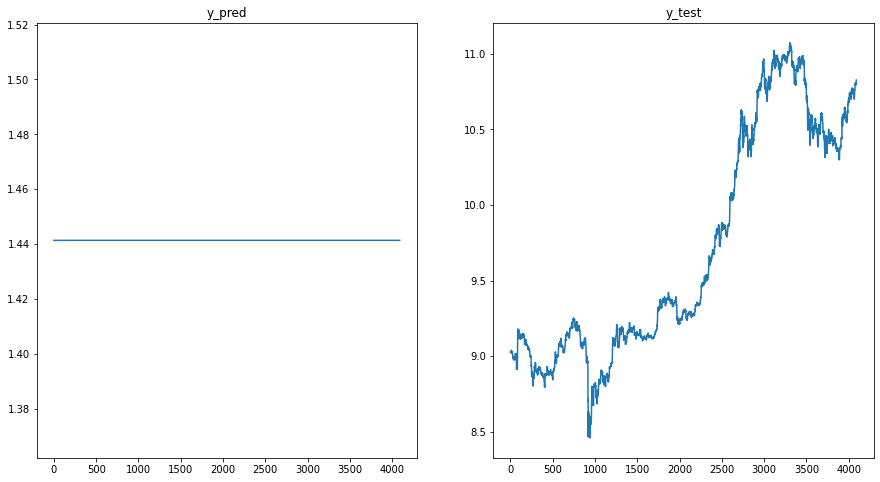

In [187]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(y_preda)
axs[0].set_title("y_pred")
axs[1].plot(y_test_unscaleda)
axs[1].set_title("y_test")
plt.show()

In [68]:
len(y_pred)

4090

In [69]:
len(y_test_unscaled)

NameError: name 'y_test_unscaled' is not defined

In [75]:
y_test_unscaled

array([[ 9638.495 ,  9659.945 ,  9628.8875,  9645.0725],
       [ 9649.365 ,  9661.99  ,  9604.7975,  9612.4425],
       [ 9473.97  ,  9496.0275,  9387.2275,  9426.485 ],
       ...,
       [44198.0825, 44414.575 , 44034.7175, 44248.8275],
       [44280.3475, 44498.065 , 44051.0225, 44286.3225],
       [44430.99  , 44598.83  , 44419.58  , 44598.83  ]])

In [ ]:
y_pred.shape

In [ ]:
np.mean(np.abs(y_test_unscaled - y_pred))

In [ ]:
6.56406288],
       [6.5522137 ],
       [6.53968617

In [203]:
np.exp(6.53968617)

692.0693518275402